<a href="https://aniti.univ-toulouse.fr/" ><img src="https://www.actuia.com/wp-content/uploads/2019/07/logo_ANITI1-696x348.jpg" style="float:left; max-width:210px; display: inline" alt="ANITI"/></a>  

<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:right" height="75" alt="INSA"/></a> 



# Détection de Biais et Discriminations en IA

**Données `Adult Income`**

**Résumé**
Analyse de données extraites d'un recensement aux USA de 1994 et disponibles sur le [dépôt de l'UCI](http://archive.ics.uci.edu/ml/). Ces données permettent de mettre en relation le niveau de revenu (inférieur ou supérieur à 50k$) avec d'autres variables dont certaines sensibles car indiquant l'appartenance à un groupe en principe protégé par la loi: genre, origine ethnique. Différents indicateurs de biais donc de sources de discrimination vis à vis d'un groupe sont définis et illustrés sur ces données. Les principaux relativement consensuels dans la littérature sont l'effet disproportionné ou *disparate impact* (DI), le taux d'erreur conditionnel et des mesures associées à l'asymétrie des matrices de confusion conditionnellement au groupe. Les résultats montrent que les biais de société présents dans les données d'apprentissage sont fidèlement reproduits par l'apprentissage et même renforcés. C'est typiquement un cas de discrimination notamment avec une régression logistique linéaire, moins nettement avec des modèles non linéaires. La correction de cas individuels détectés par le *testing* est inefficace pour une correction au niveau du groupe. En revanche l'utilisation d'algorithmes non linéaires (arbre ou forêt aléatoire) spécifiques: un par classe femmes et hommes annule l'effet discriminatoire, ne réduit pas les écarts des taux d'erreur conditionnels mais rend semblables les taux de faux et vrais positifs.

## Introduction
### Les données
Des données publiques disponibles sur le site [UCI repository](http://archive.ics.uci.edu/ml/) sont extraites de la base de données issue du recensement réalisé aux Etats Unis en 1994. Les deux fichiers *train* et *test* on été réunis en un seul. Ces données son largement utilisées et font référence comme outil de *benchmark* pour comparer les performances de méthodes d’apprentissage. L’objectif est de prévoir, avec plus ou moins de biais, la variable binaire "revenu annuel" supérieur ou inférieur à 50k$. Cette prévision n'impacte pas la personne mais comme la démarche et le contexte sont tout à fait similaires à ce que pourrait faire une banque pour évaluer un risque de crédit, c'est exemple est très illustratif. Il est d'ailleurs systématiquement utilisé pour comparer les propriétés des algorithmes d'apprentissage équitables (*fair learning*) car contrairement à beaucoup d'autres jeux de données utlisés pour cette fin (*e.g. german credit bank*), la vraie valeur de la variable cible est connue ainsi que l'origine ethnique des personnes concernées.

Dans les données initiales, 48.842 individus sont décrits par les 14 variables du tableau ci-dessous:


|Num|Libellé|Ensemble de valeurs|
|-|---------:|-------------------:|
|1|`Age`|real|
|2|`workClass`|Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked|
|3|`fnlwgt`|real|
|4|`education`|Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool|
|5|`educNum`|integer|
|6|`mariStat`|Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse|
|7|`occup`|Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces|
|8|`relationship`|Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
|9|`origEthn`|White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black|
|10|`sex`|Female, Male|
|11|`capitalGain`|real| 
|12|`capitalLoss`|real|
|13|`hoursWeek`|real|
|14|`nativCountry`|United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands|
|15|`income`|>50K, <=50K|


### Préparation des données

Le traitement commence par une préparation détaillée des données:
- lecture et prise en charge des données en remarquant que la variable `fnlwgt` (Final sampling weight) a un [statut particulier](http://web.cs.wpi.edu/~cs4341/C00/Projects/fnlwgt) pas très clair; elle est éliminée;
- exploration élémentaire et multidimensionnelle (AFCM) afin de représenter les sources des biais présents.

Celle-ci conduit à nettoyer les données notamment en supprimant celles manquantes, des erreurs ou incohérences et à regrouper certaines modalités très dispersée, supprimer des variables redondantes. Cette phase est notoirement différente de la stratégie de Friedler et al. (2019) qui, par principe, analysent des données brutes.

### Estimation des biais

Parmi tous les critères de biais existant susceptibles de mettre en évidence une discrimination, trois ont été privilégiés: 
- l'effet disproportionné (*disparate impact*), 
- la comparaison des taux d'erreur conditionnels 
- une mesure d'asymétrie de la matrice de confusion conditionnelle: *Conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds* cf. Vermat et Rubin (2018).

L'accent est mis sur l'estimation de l'effet disproportionné  vis-à-vis de deux variables sensibles: genre et origine ethnique. L'approximation de l'intervalle de confiance (*delta method*) est comparée avec une estimation Bootstrap conduisant aux mêmes résutlats. es estimations sont calculées sur les données initiales de la base (biais de société) puis sur les prévisions du seuil de revenu obtenues par différents modèles et algorithmes (risque de discrimination).

Sont également évaluées (estimation ponctuelle) les précisions et les asymétries des rapports de cote conditionnelles aux modalités de la variable sensible. 

### Biais et discriminations

Les algorithmes privilégiés sont la régression logistique, linéaire et quadratique (avec interactions), les arbres binaires de décision et les forêts aléatoires. Bien d'autres algorithmes pourraient être testés mais le fond reste le même: en matière de discrimination deux points semblent importants, voire à considérer en priorité: 
- le possible déséquilibre ou sous-représentation d'une classes de la variable sensible, 
- la capacité de l'algorithme à prendre en compte des interactions et donc des composantes non linéaires impliquant la variable sensible.

Ces deux facteurs semblent avoir un impact déterminant sur le renforcement significatif des biais d'un algorithme et donc sur la discrimination,condamnable par la loi, envers un groupe. Ils sont clairement mis en évidence en comparant les effets discriminatoires de différents algorithmes 
- linéaires ou non linéaires (avec un certains niveau d'interactions), 
- en introduisant une pondération pour compenser le déséquilibre,
- en considérant deux modèles, un par classe de la variable sensible.

D'autres points sont également traités: 
- effet négligeable de la suppression de la variable sensible du modèle de prévision sur l'effet discriminatoire d'un algorithme,
- détection d'une discrimination individuelle par *testing* et effet négligeable de sa correction sur la dicrimination de groupe;
- correction élémentaire de biais par ajustement du seuil de la décision.

## Exploration des données
### Lecture et premières transformations
La lecture et la transformation des données brutes du dépôt de l'UCI sont obtenues directement en exécutant un code source en R. Consulter le code du programme pour comprendre les transformations qui ont été réalisées sur les données brutes. Cette étape peut être rendue plus efficace (programme plus concis et exécution plus rapide) en utilisant la librairie `dplyr` très adaptée à cet usage.

Charger les données et le programme dans le répertoire courant en même temps que ce tutoriel ou changer de chemin pour y accéder directement. 

Certaines variables qualitatives sont recodées afin de regrouper des classes à trop faibles effectifs, les variables quantitatives, dont l'âge, sont découpées en classes afin d'en construire des versions qualitatives en vue d'une AFCM.

In [1]:
source("dataPrepAdultCensus.R")
summary(dataBase)

      age                workClass         fnlwgt              education    
 Min.   :18.00   Federal-Govt : 1390   Min.   :  13492   HS-grad    :14766  
 1st Qu.:28.00   Not-Working  :   21   1st Qu.: 117404   HS-Graduate: 9892  
 Median :37.00   Other-Govt   : 5023   Median : 178390   Bachelors  : 7569  
 Mean   :38.79   Private      :32856   Mean   : 189858   Dropout    : 5182  
 3rd Qu.:47.00   Self-Employed: 5425   3rd Qu.: 237998   Associates : 3466  
 Max.   :90.00                         Max.   :1490400   Masters    : 2512  
                                                         (Other)    : 1328  
    educNum               mariStat              occup      
 Min.   : 1.00   Married      :21079   Admin       : 5501  
 1st Qu.: 9.00   Never-Married:14100   Blue-Collar :14732  
 Median :10.00   Not-Married  : 8259   Other-occups: 2391  
 Mean   :10.16   Widowed      : 1277   Professional: 5992  
 3rd Qu.:13.00                         Sales       : 5272  
 Max.   :16.00          

### Description statistique élémentaire
Mettre en évidence des difficultés présentes sur certaines variables ou couples de variables.

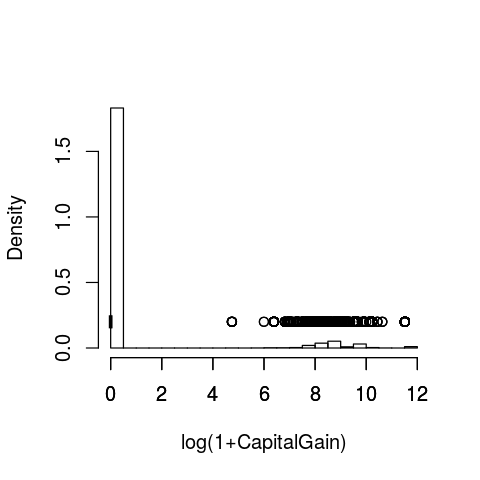

In [2]:
options(repr.plot.width=4, repr.plot.height=4)
hist(dataBase[,"LcapitalGain"],probability=T, main="",xlab="log(1+CapitalGain)")
boxplot(dataBase[,"LcapitalGain"], horizontal=TRUE,boxwex=.2,  outline=TRUE,  
        frame=F, col = "lightgrey", add = TRUE,at=0.2)

Nécessité de transformer certaines variables avant de contruire des modèles linéaires puis mise en évidence d'incohérences et de fortes redondances entre certaines variables.

In [3]:
table(dataBase$relationship,dataBase$sex)   

                
                 Female  Male
  Husband             1 18659
  Not-in-family    5404  6274
  Other-relative    599   721
  Own-child        2707  3477
  Unmarried        3649  1133
  Wife             2090     1

In [4]:
table(dataBase$education,dataBase$educNum)  

             
                  1     2     3     4     5     6     7     8     9    10    11
  Associates      0     0     0     0     0     0     0     0     0     0  1959
  Bachelors       0     0     0     0     0     0     0     0     0     0     0
  Doctorate       0     0     0     0     0     0     0     0     0     0     0
  Dropout        72   222   446   819   644  1073  1387   519     0     0     0
  HS-grad         0     0     0     0     0     0     0     0 14766     0     0
  HS-Graduate     0     0     0     0     0     0     0     0     0  9892     0
  Masters         0     0     0     0     0     0     0     0     0     0     0
  Prof-School     0     0     0     0     0     0     0     0     0     0     0
             
                 12    13    14    15    16
  Associates   1507     0     0     0     0
  Bachelors       0  7569     0     0     0
  Doctorate       0     0     0     0   544
  Dropout         0     0     0     0     0
  HS-grad         0     0     0 

In [5]:
table(dataBase$mariStat,dataBase$relationship)

               
                Husband Not-in-family Other-relative Own-child Unmarried  Wife
  Married         18660            19            184       125         0  2091
  Never-Married       0          6667            793      5423      1217     0
  Not-Married         0          4305            284       616      3054     0
  Widowed             0           687             59        20       511     0

In [6]:
table(dataBase$origEthn,dataBase$nativCountry)

             
              British-Commonwealth China Euro_1 Euro_2 Latin-America Other
  Amer-Indian                    0     1      1      2            12     0
  Asian                        125   185      4    101            13    61
  Black                         11     0     10      0           230     8
  Other                         12     0      2      1           125    11
  White                        333    10    313    229          1157   198
             
              SE-Asia South-America United-States
  Amer-Indian       1             1           410
  Asian           416             0           397
  Black             4             2          3929
  Other             0            31           166
  White            20           278         35905

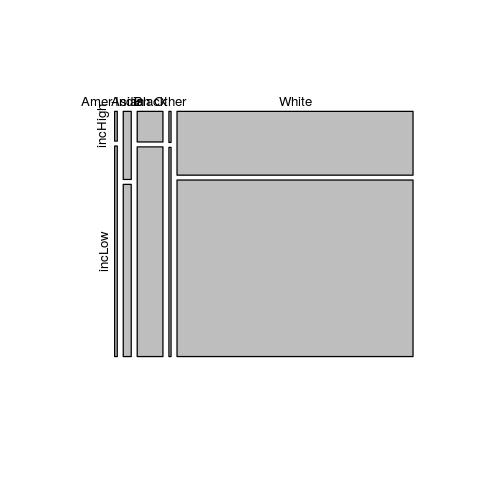

In [7]:
mosaicplot(table(dataBase[,"origEthn"],dataBase[,"income"]),main="")

Quelques modifications sont apportées de la base. Certaines variables en versions quantitatives et qualitatives comme le nombre d'heures par semaine, l'âge ou le niveau d'éducation sont conservées. Des variables sont supprimées afin de ne garder qu'une seule présence d'une information sensible: genre et origine ethnique.
- Suppression de la variable 3 `fnlwgt` qui n'a guère de signification pour cette analyse.
- Création d'une variable binaire `Child`: présence ou non d'enfants.
- Suppression de la variable 8 `relationship` redondante avec le genre et le statut marital,
- Suppression de la variable 14 `nativCountry` redondante avec l'origine ethnique.
- La variable 9 `originEthn` est simplifiée à 2 classes: CaucYes *vs.* CaucNo

**Attention** Pour la suite, il est important que les niveaux des facteurs soient ordonnés de façon cohérente pour la bonne interprétation des tables de contingence et de leurs effectifs. Par convention, les modalités pré-jugées socialement "dévavorables": revenu faible, femme, non caucasien, précèdent les autres (codées 0): revenu élevé, homme, caucasien (codées 1). Il faut donc soit réordonner les niveaux de la variable `income` ou renommer les modalités pour faire correspondre l'ordre alphabétique. Ce deuxième choix est exécuté.

In [8]:
dataBase[,"child"]=as.factor(ifelse(dataBase$relationship=='Own-child',"ChildYes","ChildNo"))
dataBase[,"origEthn"]=as.factor(ifelse(dataBase$origEthn %in% c('Amer-Indian','Asian','Black','Other'),"CaucNo","CaucYes"))
dataBase[,"income"]=as.factor(ifelse(dataBase$income=='incLow',"incB","incH"))
datBas=dataBase[,-c(3,8,14)]
summary(datBas)

      age                workClass           education        educNum     
 Min.   :18.00   Federal-Govt : 1390   HS-grad    :14766   Min.   : 1.00  
 1st Qu.:28.00   Not-Working  :   21   HS-Graduate: 9892   1st Qu.: 9.00  
 Median :37.00   Other-Govt   : 5023   Bachelors  : 7569   Median :10.00  
 Mean   :38.79   Private      :32856   Dropout    : 5182   Mean   :10.16  
 3rd Qu.:47.00   Self-Employed: 5425   Associates : 3466   3rd Qu.:13.00  
 Max.   :90.00                         Masters    : 2512   Max.   :16.00  
                                       (Other)    : 1328                  
          mariStat              occup          origEthn         sex       
 Married      :21079   Admin       : 5501   CaucNo : 6272   Female:14450  
 Never-Married:14100   Blue-Collar :14732   CaucYes:38443   Male  :30265  
 Not-Married  : 8259   Other-occups: 2391                                 
 Widowed      : 1277   Professional: 5992                                 
                       Sa

Quelques mosaicplots importants montrant le liens des variables sensibles avec la cible (seuil de revenu).

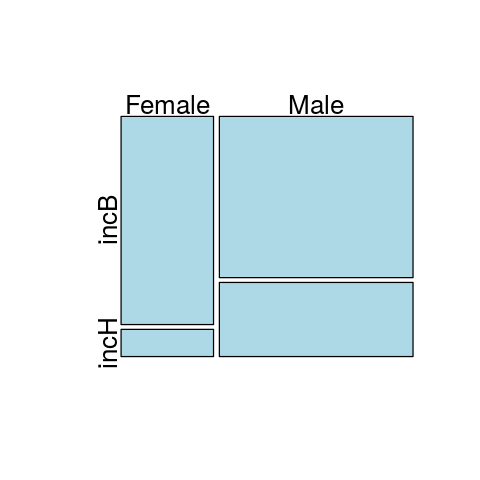

In [9]:
mosaicplot(table(datBas[,"sex"],datBas[,"income"]),main="", col="lightblue",cex=1.3)

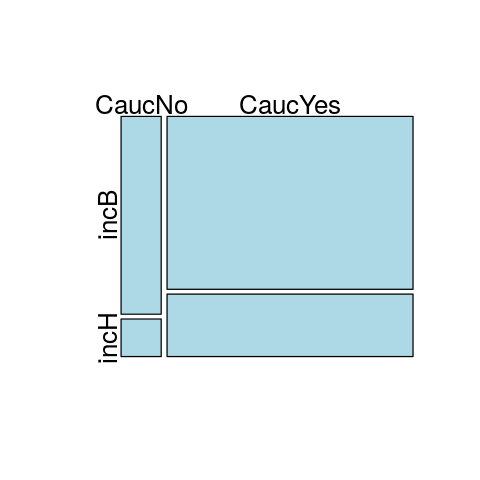

In [10]:
mosaicplot(table(datBas[,"origEthn"],datBas[,"income"]),main="",col="lightblue",cex=1.3)

**Q** Commentaires sur le biais présent dans la base, les déséquilibres des classes.

### [Analyse factorielle multiple des correspondances](http://wikistat.fr/pdf/st-m-explo-afcm.pdf)
Cette méthode permet d'avoir une vue d'ensemble de la structure des liaisons entre les variables qualitatives prises 2 à 2. 

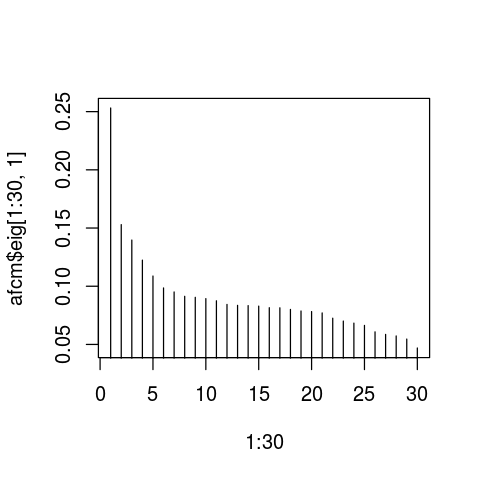

In [11]:
library(FactoMineR)
dataq=datBas[,c(2,3,5:10,12,15:17)]
afcm=MCA(dataq,graph=FALSE)
plot(1:30,afcm$eig[1:30,1],type="h")

Il pourrait être utile de considérer 3 ou 4 axes mais seuls deux sont utilisés dans cette approche élémentaire. 

**Remarque** Cette étape permettrait d'anonymiser les données pour des traitements ultérieurs "confidentiels". Les variables qualitatives suceptibles de ré-identifier les données sont remplacées par les composantes principales de l'ACP des vecteurs profils lignes du tableau disjontif complet. Les liens entre individus sont conservés sans possibilité de les identifier.

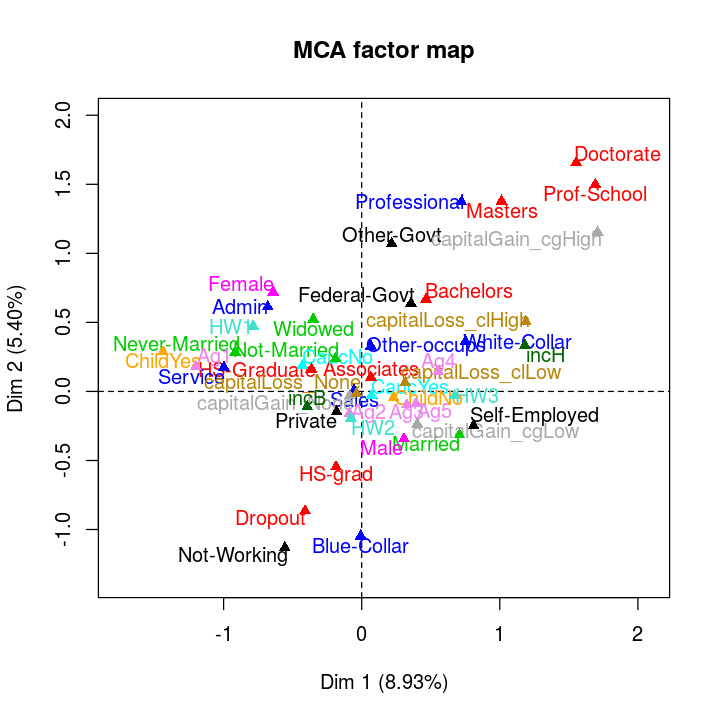

In [12]:
options(repr.plot.width=6, repr.plot.height=6)
plot.MCA(afcm,invisible=c("ind"),habillage="quali")

Remarquer la très forte et attendue liaison entre niveau d'éducation et activité selon un axe de dispersion suivant la première bissectrice, lui même en relation avec les modalités haut et bas revenus alors que le genre, en première approximation, semble orthogonal à cet axe mais en relation avec le type d'activité et le nombre d'heures de travail par semaine.

Ce graphique laisse penser que le lien entre genre et niveau de revenu ne serait pas dû à une sous qualification des femmes mais à une moindre activité (travail partiel) ou à des types d'emplois moins rémunérés.

Cette représentation est complétée en projetant les individus colorés selon la variable revenu. De façon triviale, les hauts revenus se concentrent du côté des niveaux d'éducation les plus élevés.

*En résumé*: un lien direct entre revenu et niveau d'éducation, pas nécessairement de lien entre genre et niveau d'éducation mais un "frein" au revenu lié au type de travail ou d'occupation : administratif, service... et à de possibles temps partiels.

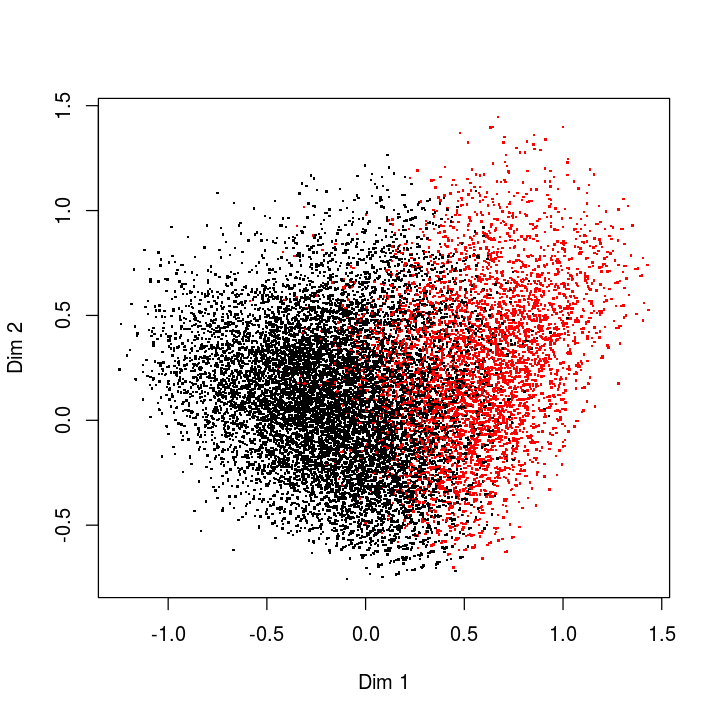

In [13]:
plot(afcm$ind$coord,type="p",pch=".",cex=2,col=as.integer(dataBase$income))

## Premiers modèles de prévision du seuil de revenu
Une comparaison détaillée (cf. le [tutoriel](https://github.com/wikistat/Apprentissage/blob/master/Adult-Census/Apprent-Python-AdultCensus.ipynb)) de la plupart des modèles et algorithmes de prévision du seuil de revenu en fonction des différentes variables met en évidence des résultats de prévision un peu meilleurs obtenus par l'algorithme de *gradient boosting* (version xtrem). Néanmoins, on peut se limiter ici à un choix plus restreint de modèles et algorithmes: 
- la régression logistique (linéaire et quadratique), rapide, compétitive et interprétable; 
- un arbre de décision seul ocnduit à une meilleure précision mais s'avère trop complexe (profondeur) pour être interprétable; 
- les forêts aléatoires conduisent à une meilleure précision.

### Echantillons
La base de données est divisée en deux échantillons d'apprentissage et de test.

In [14]:
summary(datBas)

      age                workClass           education        educNum     
 Min.   :18.00   Federal-Govt : 1390   HS-grad    :14766   Min.   : 1.00  
 1st Qu.:28.00   Not-Working  :   21   HS-Graduate: 9892   1st Qu.: 9.00  
 Median :37.00   Other-Govt   : 5023   Bachelors  : 7569   Median :10.00  
 Mean   :38.79   Private      :32856   Dropout    : 5182   Mean   :10.16  
 3rd Qu.:47.00   Self-Employed: 5425   Associates : 3466   3rd Qu.:13.00  
 Max.   :90.00                         Masters    : 2512   Max.   :16.00  
                                       (Other)    : 1328                  
          mariStat              occup          origEthn         sex       
 Married      :21079   Admin       : 5501   CaucNo : 6272   Female:14450  
 Never-Married:14100   Blue-Collar :14732   CaucYes:38443   Male  :30265  
 Not-Married  : 8259   Other-occups: 2391                                 
 Widowed      : 1277   Professional: 5992                                 
                       Sa

In [15]:
datBas=datBas[,c("age","educNum","mariStat","occup","origEthn",
                 "sex","hoursWeek","income","LcapitalGain","LcapitalLoss","child")]
summary(datBas)
write.csv(datBas,file="adultBase-R.csv",row.names = FALSE)

      age           educNum               mariStat              occup      
 Min.   :18.00   Min.   : 1.00   Married      :21079   Admin       : 5501  
 1st Qu.:28.00   1st Qu.: 9.00   Never-Married:14100   Blue-Collar :14732  
 Median :37.00   Median :10.00   Not-Married  : 8259   Other-occups: 2391  
 Mean   :38.79   Mean   :10.16   Widowed      : 1277   Professional: 5992  
 3rd Qu.:47.00   3rd Qu.:13.00                         Sales       : 5272  
 Max.   :90.00   Max.   :16.00                         Service     : 4846  
                                                       White-Collar: 5981  
    origEthn         sex          hoursWeek      income       LcapitalGain   
 CaucNo : 6272   Female:14450   Min.   : 1.00   incB:33511   Min.   : 0.000  
 CaucYes:38443   Male  :30265   1st Qu.:40.00   incH:11204   1st Qu.: 0.000  
                                Median :40.00                Median : 0.000  
                                Mean   :41.17                Mean   : 0.747  
  

In [16]:
set.seed(11) # initialisation du générateur
# Extraction des échantillons
test.ratio=.2   # part de l'échantillon test
npop=nrow(datBas) # nombre de lignes dans les données
nvar=ncol(datBas) # nombre de colonnes
# taille de l'échantillon test
ntest=ceiling(npop*test.ratio) 
# indices de l'échantillon test
testi=sample(1:npop,ntest)
# indices de l'échantillon d'apprentissage
appri=setdiff(1:npop,testi) 

In [17]:
# construction de l'échantillon d'apprentissage
datApp=datBas[appri,]
# construction de l'échantillon test 
daTest=datBas[testi,]

### Prévision par régression logistique
Remarquer que la présence des versions qualitatives (découpage en classe) des variables quantitatives introduit une part de non linéarité dans le modèle par la présence des indicatrices des classes.

La fonction ci-dessous calcule le taux d'erreur usuel de la matrice de confusion. Avec l'ordonnencement des modalités, les bien classés sont les termes diagonaux de la matrice de confusion.

In [18]:
tauxErr=function(table){round((table[1,2]+table[2,1])/sum(table)*100,2)}

In [19]:
# estimation du modèle complet
log.lm=glm(income~.,data=datApp,family=binomial)
# significativité des paramètres
anova(log.lm,test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,35771,40227.31,NA
age,1,1865.39750,35770,38361.91,0.000000e+00
educNum,1,4247.88595,35769,34114.03,0.000000e+00
mariStat,3,6299.40893,35766,27814.62,0.000000e+00
occup,6,792.03697,35760,27022.58,8.090064e-168
origEthn,1,19.96324,35759,27002.62,7.894531e-06
sex,1,51.34567,35758,26951.27,7.745273e-13
hoursWeek,1,439.60497,35757,26511.67,1.319533e-97
LcapitalGain,1,1239.63939,35756,25272.03,1.481393e-271
LcapitalLoss,1,304.08396,35755,24967.94,4.246522e-68


**Q** Commentaire sur la significativité des paramètres.

In [20]:
# Prévision
pred.log=predict(log.lm,newdata=daTest,type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred.log>0.5,daTest$income)
confMat

       
        incB incH
  FALSE 6154  950
  TRUE   526 1313

In [21]:
tauxErr(confMat)

[1] 16.5

A titre de comparaison, l'algorithme des forêts aléatoires est exécuté avec les options par défaut.

**Q** Quelles sont ces options par défaut?

In [22]:
library(randomForest)
rf.mod=randomForest(income~.,data=datApp)
pred.rf=predict(rf.mod,newdata=daTest,type="response")
confMat=table(pred.rf,daTest$income)
confMat
tauxErr(confMat)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


       
pred.rf incB incH
   incB 6292  870
   incH  388 1393

[1] 14.07

Un modèle de régression logistique avec interactions, donc quadratique, nécessite une sélection de variables ici pas-à-pas (*stepwise* ou `both`). Le temps d'exécution est relativement long.

In [ ]:
#################
# Ne pas exécuter
################

# régression avec le modèle minimum
log.qm=glm(income~1,data=datApp,family=binomial)
# algorithme stepwise en précisant le plus grand 
# modèle possible
log.qm.stepb=step(log.qm,direction="both",
  scope=list(lower=~1,upper=~(age+educNum+mariStat+occup+origEthn+sex+hoursWeek+
  LcapitalGain+LcapitalLoss+child)^2), family=binomial)

In [ ]:
anova(log.qm.stepb,test="Chisq")

In [ ]:
# Prévision
pred.logqm=predict(log.qm.stepb,newdata=daTest,type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confmat=table(pred.logqm>0.5,daTest[,"income"])
tauxErr(confmat)
confmat

La prise en compte d'un modèe avec interactions n'améliore pas sensiblement la précision de la régression logisitique sur ces données. Il suffit donc par la suite de se limiter au modèle linéaire sans interactionpour étudier les questions de biais et discrimination. En revanche, un algorithme non linéaire (forêts aléatoires) permet de réduire significativement cette erreur; 16.5% pour la régression logistique incluant toutes les variables et ci-dessus 14.7% pour les forêts aléatoires. Le boosting ou même la version XGboost permet d'améliorer encore un peu ce score mais au prix d'optimisaitons complexes des hyperparamètres. L'objectif n'est pas ici d'obtenir la meilleure prévision comme dans le [calepin](https://github.com/wikistat/Apprentissage/tree/master/Adult-Census) concerné qui les compare systématiquement. Pour viser l'objectif de détection de biais, un modèle simplifié suffit car les mêmes questions de discrimination sont soulevées et avec des temps de calcul plus satisfaisants; arbre de décision et forêt aléatoire seront utilisés pour le sdernières comparaisons.

### Modèle de régression sans la variable genre
Une approche naïve pour construire un apprentissage "loyal" consiste à supprimer la variable sensible. Le modèle de régression logistique est donc estimé sans cette variable afin d'évaluer l'impact sur le biais.

In [23]:
# estimation du modèle sans la variable genre
log_g.lm=glm(income~.,data=datApp[,-6],family=binomial)

In [24]:
# Prévision
pred_g.log=predict(log_g.lm,newdata=daTest[,-8],type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred_g.log>0.5,daTest$income)
confMat

       
        incB incH
  FALSE 6157  953
  TRUE   523 1310

In [25]:
tauxErr(confMat)

[1] 16.5

La qualité de prévision n'est pas affectée.

### Régression logistique sans l'origine
Même chose mais sans cette fois sans la variable origine ethnique.

In [26]:
log_o.lm=glm(income~.,data=datApp[,-5],family=binomial)
# Prévision
pred_o.log=predict(log_o.lm,newdata=daTest[,-5],type="response")
# Matrice de confusion  et erreur
confMat=table(pred_o.log>0.5,daTest$income)
confMat; tauxErr(confMat)

       
        incB incH
  FALSE 6157  954
  TRUE   523 1309

[1] 16.52

Même remarque.

## Estimation de l'effet disproportionné
### Définition
Les mesures de discrimination indirecte ou de groupe sont basées sur un critère d'effet disproportionné ou *disparate impact* (*DI*) apparu aux USA en 1971 pour détecter des situations discriminatoires à l'embauche (Barocas et Selbst; 2016). Ce critère est défini par le rapport de deux probabilités. La probabilité de bénéficier d'une situation ou décision favorable (revenu élevé, crédit, emploi, logement...) pour une personne du groupe protégé par la loi: femme ou origine non caucasienne, sur la même probabilité pour une personne de l'autre groupe: homme ou origine caucasienne.

*Notations*: 

- $Y$ est la variable cible ou à expliquer, ici le revenu, $Y=1$ revenu élevé *vs* $Y=0$; 
- $g(X)=\hat{Y}$ le score élevé ou faible ou prévision du revenu, $g(X)=\hat{Y}=0$: prévision d'un revenu faible;
- $S$ est la variable sensible qui désigne le groupe en principe protégé par la loi contre une possible discrimination. Il s'agit ici du genre ou de l'origine ethnique réduite à 2 modalités: caucasien ($S=1$) ou non caucasien ($S=0$). 

L'effet disproportionné mesure une situation de biais de société déjà présent dans la base de données. 
$$DI=\frac{P(Y=1|S=0)}{P(Y=1|S=1)}.$$
Il est estimé à partir des valeurs de la table de contingence croisant les variables $Y$ et $S$ par le rapport:
$$\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$$

Appliqué à la prévision $g(X)=\hat{Y}$ de la variable cible $Y$, il mesure le biais de cette prévision et donc le risque de discrimination opéré par la prévision.

### Fonction `dispImp`
Une fonction R calcule le $DI$ et fournit de plus une estimation par intervalle de confiance (Besse et al. 2018) décomposant la fonction de densité de la statistique de test par la *delta method*. Cette fonction a trois arguments:   
- la variable $S$ considérée comme sensible: un facteur à deux niveaux ordonnés "défavorable" puis "favorable";
- la variable cible $Y$ ou sa prévision $g(X)=\hat{Y}$: également un facteur à deux niveaux défavorable pyuis favorable;
- le risque de l'intervalle de confiance, par défaut 5%.

Cette fonction renvoie les trois estimations $DI$ et $IC_g$, $IC_d$ bornes de l'intervalle de confiance.

In [27]:
source("../Functions/dispImp.R")

### Effet disproportionné de la base d'apprentissage
Calculé sur les données initiales, le *disparate impact* ou effet disproportionné met en évidence un biais social fort. Les variables sensibles sont le genre puis l'origine ethnique. La fonction `dispImp` nécessite que les niveaux des facteurs soient dans l'ordre lexicographique: niveaux "défavorable" puis "favorable".

#### Ségrégation vis à vis du genre
Table de contingence croisant $Y$ (revenu) avec $S$ (genre).

In [28]:
tableDI=table(datBas$income,datBas$sex)
tableDI

      
       Female  Male
  incB  12781 20730
  incH   1669  9535

*Estimation ponctuelle* de $DI=\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$

In [29]:
round((tableDI[2,1]/(tableDI[1,1]+tableDI[2,1]))/(tableDI[2,2]/(tableDI[1,2]+tableDI[2,2])),3)

[1] 0.367

*Estimation par intervalle de confiance* approché par *delta method*. 

In [30]:
round(dispImp(datBas[,"sex"],datBas[,"income"]),3)

[1] 0.349 0.367 0.384

*Estimation bootstrap de l'intervalle de confiance*

L'estimation approchée par la *delta method* est comparée à une estimation bootstrap de l'intervalle de confiance. En effet, l'estimation du *DI* est instable mais les estimations sur des échantillons bootstrap restent bien dans la zone de risque contrôlée par l'intervalle de confiance. 

In [ ]:
# ne pas exécuter
B=1000 
set.seed(11)
n=nrow(datBas)
res=matrix(0,B,3)
for (i in 1:B)
    {
    boot=sample(n,n,replace=T)
    res[i,]=dispImp(datBas[boot,"sex"],datBas[boot,"income"])
    }

In [ ]:
options(repr.plot.width=5, repr.plot.height=4)
plot(res[,2],ylim=c(0.3,0.45),pch='.')
lines(res[,2],col=3,pch='.')
abline(h=0.343,col=2)
abline(h=0.386,col=2)

Une fonction de la librairie `boot` fournit une estimation bootstrap de l'intervalle de confiance.

In [ ]:
library(boot)
fc <- function(d, i){ 
    d2 <- d[i,]
    return(statistic=dispImp(d2$sex,d2$income)[2])
}
set.seed(11)
bootDI <- boot(datBas,fc, R=1000)
bootDI

In [ ]:
boot.ci(boot.out = bootDI, type = "perc")

Comme attendu, l'intervalle de confiance issu de l'approximation par *delta method*: $[0.349, 0.384]$ se confond avec  celui obtenu par estimation bootstrap: $[0.349, 0.385]$.

***NB*** Compte tenu des temps de calcul, l'estimation approchée de l'IC par *delta method* est à privilégier!

#### Biais vis à vis de l'origine

In [31]:
round(dispImp(datBas$origEthn,datBas$income),3)

[1] 0.566 0.601 0.637

Biais nettement plus important selon le genre que selon l'origine ethnique.

### Effet disproportionné des prévisions par régression logistique
Le même ratio ou impact disproportionné calculé sur les prévisions $g(X)$ de $Y$ plutôt que sur $Y$ mesure explicitement l'effet de la prévision. Il revient à évaluer l'égalité des taux de prévision favorable. 

La valeur seuil de la probabilité pour prédire le niveau de revenu est fixée par défaut à 0.5.

In [32]:
Yhat=as.factor(pred.log>0.5)

In [ ]:
# Ne pas exécuter
Yhatq=as.factor(pred.logqm>0.5)

#### Avec régression logistique et par genre
La prévision reproduit et même renforce significativement le biais social pour le genre avec la régression logistique linéaire car les intervalles de confiance sont disjoints. En revanche, la discriminaiton n'est pas significative avec la régression logistique quadratique. Résultat assez surprenant mais conforme à ceux obtenus en exécutant les codes en python avec la librairie `Scikit-learn`n qui estime une verson plus flexible (plus de paramètres) de la régression logistique.

***NB*** le *DI* est très sensible à l'algorithme d'apprentissage utilisé et ceci indépendamment de la précision de la prévision.

In [34]:
round(dispImp(daTest[,"sex"],Yhat),3)

[1] 0.212 0.248 0.283

In [ ]:
# ne pas exécuter
round(dispImp(daTest[,"sex"],Yhatq),3)

A titre de comparaison, le DI obtenu par *random Forest* qui, pour cet échantillon test, ne discrimine pas.

In [36]:
round(dispImp(daTest[,"sex"],pred.rf),3)

[1] 0.329 0.375 0.420

#### Avec régression logistique et par origine
Le renforcement du biais selon l'origine n'est pas, sur ces données, statistiquement significatif.

In [37]:
round(dispImp(daTest[,"origEthn"],Yhat),3)

[1] 0.442 0.524 0.607

In [36]:
round(dispImp(daTest[,"origEthn"],Yhatq),3)

ERROR: Error in dispImp(daTest[, "origEthn"], Yhatq): objet 'Yhatq' introuvable


### Effet disproportionné des prévisions sans la variable sensible
L'approche très naïve qui consiste à supprimer la variable sensible du modèle n'a finalement pas d'effet sur le biais et donc le caractère discriminatoire de l'algorithme.
#### En supprimant la variable genre

In [38]:
Yhat_g=as.factor(pred_g.log>0.5)
round(dispImp(daTest[,"sex"],Yhat_g),3)

[1] 0.232 0.269 0.305

#### En supprimant la variable origine

In [39]:
Yhat_o=as.factor(pred_o.log>0.5)
round(dispImp(daTest[,"origEthn"],Yhat_o),3)

[1] 0.498 0.586 0.673

De même que les erreurs de prévisions restent stables, l'effet disproportionné n'est pas statistiquement affecté par la suppression de la variable sensible du modèle. Le déterminisme social est plus fort que la présence de la variable sensible: *une femme ou une personne non caucasienne travaille de toute façon moins ou de façon moins qualifiée quelque soit son niveau d'éducation*. La suppression de la variable sensible n'impacte donc pas la modélisation. 

### Impact de l'algorithme
Comme vu précédemment, la régression logistique renforce de façon importante voire statistiquement significative le bais déjà présent dans les données. Ce n'est pas le cas de *random forest* sur cet échantillon test.  Plus précisément, Friedler et al. (2019) mettent en oeuvre une comparaison exhaustive de plusieurs algorithmes de débiaisage sur 5 jeux de données publics dont celles issues du recensement `adultCensus`. Les résultats sont comparés avec ceux "*base line*" d'algorithmes d'apprentissage classique (SVM, logistique, arbre de décision, bayésien naïf). Les résultats affichés mettent en évidence une forte disparité des *DI* calculés pour ces différents algorithmes ainsi que pour différentes extractions d'échantillons tests.

 Le code ci-dessous permet de vérifier ces points en considérant (validation croisée *Monte Carlo*) 20 réplications de la séparation des échantillons d'apprentissage et de test sur lesquels sont entraînés trois algorithmes: logistique linéaire, arbre de décision, *random forest*, avant d'évaluer le DI observé sur la prévision de l'échantillon test. Les SVM ainsi que les classifieurs bayésiens naïfs considérés par Friedler et al. (2019) ne sont pas repris car ils engendrent des problèmes sans doute à cause de la présence des variables qualitatives qui doivent être tranformées en indicatrices. Ceci pourra être complété dans un deuxième temps mais ce n'est indispensable pour mettre en évidence l'influence d'un algorithme sur l'effet disproportionné.

La librairie `caret` est utilisée pour simplifier le code et réduire les temps de calcul en parallélisant. Le fichier d'entraînement est de taille importante et impose des temps de calcul rédhibitoires lors de l'optimisation des hyperparamètres qui est simplifiée car l'objectif n'est pas de rechercher la meilleure précision.

**Attention** l'exécution de la cellule ci-dessous est longue. Elle peut être sautée car les principaux résultats (précision et DI) ont été enregistrés dans deux fichiers afin de faciliter les comparaisons entre les algorithmes et avec ceux de Friedler et al. (2019).

In [76]:
##############################
# Ne pas exécuter  c'est long#
##############################
# parallélisation
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl) 

library(caret)
# extraction des données en se limitant à l'échantillon  train initial
# Variable cible
# Y=datBas[1:29000,"income"]
Y=datBas[,"income"]
# Variables explicatives
#X=datBas[1:29000,-8]
X=datBas[,-8]
# Transformation des facteurs en indicatrices pour utiliser SVM
#library(FactoMineR)
# X=data.frame(tab.disjonctif(X[,c(3,5,6,10)]),X[,-c(3,5,6,10)])

xx=11 # initialisation du générateur de nombres pseudo aléatoires
set.seed(11)
for (i in 1:20) {
inTrain = createDataPartition(X[,1],p = 0.8, list = FALSE)
# Extraction des échantillons
trainDescr=X[inTrain,]
testDescr=X[-inTrain,]
testY=Y[-inTrain]
trainY=Y[inTrain]

xTrans=trainDescr
# normalisation pas utile
# Normalisation calculée sur les paramètres de l'échantillon d'apprentissage
# xTrans=preProcess(trainDescr)
#trainDescr=predict(xTrans,trainDescr)
# Puis appliquée également à l'échantillon test
#testDescr=predict(xTrans,testDescr)
# Choix de la validation croisée
cvControl=trainControl(method="cv",number=10)
# Attention, la variable sex est remplacée par deux indicatrices
# Il faut transformée l'indicatrice de "Male" en un facteur
DI=round(dispImp(testDescr$sex,testY),3)
print(paste0("i=",i,"  DI initial:  ",DI[1],"  ",DI[2],"  ",DI[3]))
# Régression logistique
set.seed(2)
rlogFit = train(trainDescr, trainY, method = "glmStepAIC", trControl = cvControl, trace=FALSE)
# Arbre de décision
rpartFit = train(trainDescr, trainY, method = "rpart", tuneLength = 6, trControl = cvControl)
# random forest
rfFit = train(trainDescr, trainY,method = "rf", tuneGrid = data.frame(mtry = 3), trControl=trainControl(method = "none"), ntrees=500, trace=FALSE)
# bayésien naïf
# bnFit = train(trainDescr, trainY,method = "nb", tuneLength = 4, trControl = cvControl)
# SVM noyau radial
# svmFit = train(trainDescr, trainY,method = "svmRadial", tuneLength = 4, trControl = cvControl)
# 
models=list(logit=rlogFit,arbre=rpartFit,rf=rfFit)
testPred=predict(models, newdata = testDescr)
# taux de bien classés
prec=lapply(testPred,function(x)round(mean(x==testY),3))
print(paste0("Précision de logit: ",prec$logit," arbre: ",prec$arbre," rf: ",prec$rf))
#DI
DI=lapply(testPred,function(x)round(dispImp(testDescr$sex,x)[2],3))
print(paste0("DI de        logit: ",DI$logit," arbre: ",DI$arbre," rf: ",DI$rf))
}

[1] "i=1  DI initial:  0.338  0.378  0.418"
[1] "Précision de logit: 0.838 arbre: 0.844 rf: 0.863"
[1] "DI de        logit: 0.218 arbre: 0.272 rf: 0.32"
[1] "i=2  DI initial:  0.312  0.35  0.389"
[1] "Précision de logit: 0.838 arbre: 0.848 rf: 0.864"
[1] "DI de        logit: 0.22 arbre: 0.287 rf: 0.318"
[1] "i=3  DI initial:  0.302  0.339  0.377"
[1] "Précision de logit: 0.835 arbre: 0.846 rf: 0.861"
[1] "DI de        logit: 0.207 arbre: 0.258 rf: 0.306"
[1] "i=4  DI initial:  0.327  0.367  0.406"
[1] "Précision de logit: 0.829 arbre: 0.843 rf: 0.857"
[1] "DI de        logit: 0.23 arbre: 0.289 rf: 0.347"
[1] "i=5  DI initial:  0.329  0.368  0.407"
[1] "Précision de logit: 0.84 arbre: 0.846 rf: 0.864"
[1] "DI de        logit: 0.211 arbre: 0.293 rf: 0.301"
[1] "i=6  DI initial:  0.315  0.354  0.392"
[1] "Précision de logit: 0.833 arbre: 0.844 rf: 0.858"
[1] "DI de        logit: 0.217 arbre: 0.277 rf: 0.313"
[1] "i=7  DI initial:  0.333  0.373  0.414"
[1] "Précision de logit: 0.84 arbre: 

In [40]:
di=read.table("di.txt",header=T)
pr=read.table("prec.txt",header=T)
dipr=data.frame(di,pr)

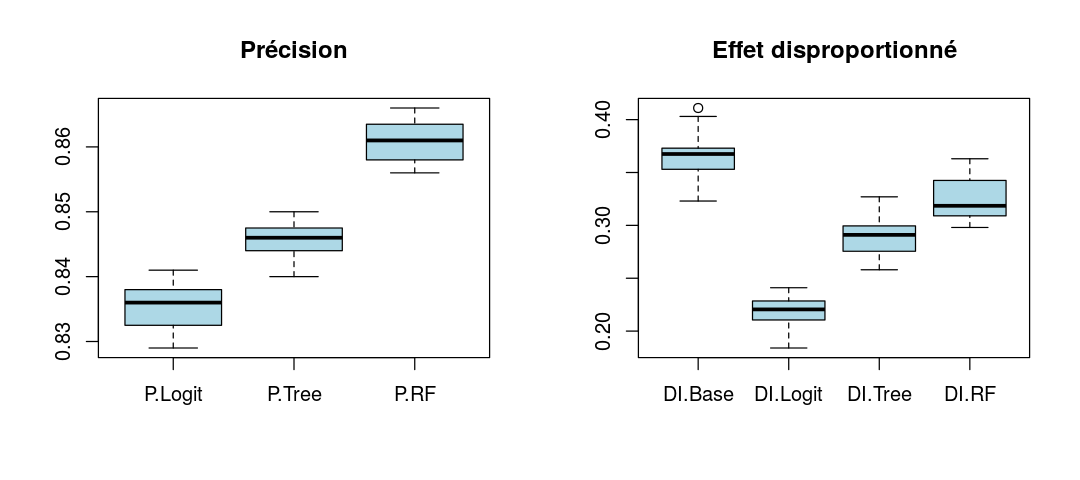

In [41]:
par(mfrow=c(1,2))
options(repr.plot.width=9, repr.plot.height=4)
boxplot(pr,main="Précision",col='lightblue');boxplot(di,main="Effet disproportionné",col='lightblue')

Comme attendu, la précision dépend fortement de l'algorithme choisie mais aussi, c'est important et moins attendu, l'estimation du *DI*. De façon relativement contre-intuitive, meilleure est la précision et moins le biais est renforcé par rapport à celui `DIbase` des données d'entraînement. Mais, pour un algorithme donné, le *DI* n'est pas corrélé à la précision sur un échantillon d'apprentissage.

In [ ]:
# ne pas exécuter
par(mfrow=c(1,3))
options(repr.plot.width=9, repr.plot.height=3)
plot(pr$Plogit,di$DIlogit);plot(pr$Parbre,di$DIarbre);plot(pr$Prf,di$DIrf)

**En résumé** les forêts aléatoire apportent deux avantages par rapport à la régression logistique: meilleure prévision et moindre discrimination mais au prix évidemment de l'interprétabilité.

**Attention** comme le rappelle Friedler et al. (2019) les résultats et conclusions peuvent changer d'un jeu de données à un autre. C'est déjà bien connu en ce qui concerne la précision de la prévision, il est nécessaire de l'intégrer dans la gestion du biais.

### Réduction du biais par correction du seuil
La suppression de la variable sensible ne corrige pas le biais. Une façon très élémentaire de le faire, même si elle peut être jugée déloyale, consiste à intervenir sur les seuils de décisions. Par défaut, ce seuil est fixé à 0.5 pour affecter la prévision à la classe. Il suffit de le modifier conditionnellement aux niveaux de la variable sensible pour intervenir directement sur le biais. 

Ainsi, un seuil plus favorable de 0.4 pour les femmes permet de retrouver une valeur de $DI$ analogue à celle des données de la base sans pour autant que le taux d'erreur en soit affecté.

In [43]:
Yhat_cs=as.factor(ifelse(daTest$sex=="Female",pred.log>0.4,pred.log>0.5))
round(dispImp(daTest[,"sex"],Yhat_cs),3)
tauxErr(table(Yhat_cs,daTest$income))

[1] 0.293 0.334 0.375

[1] 16.55

Une réduction plus marquée du seuil permet de restreindre significativement le biais de façon à ce que $0.8\in IC$; il n'y a alors plus d'effet disproportionné juridiquement significatif. Le prix à payer est la dégradation du taux d'erreur de prévision.

In [44]:
Yhat_cs=as.factor(ifelse(daTest$sex=="Female",pred.log>0.15,pred.log>0.5))
round(dispImp(daTest[,"sex"],Yhat_cs),3)
tauxErr(table(Yhat_cs,daTest$income))

[1] 0.796 0.863 0.930

[1] 18.57

Même chose pour l'origine ethnique avec une correction plus légère du seuil.

In [45]:
Yhat_co=as.factor(ifelse(daTest$origEthn=="CaucNo",pred.log>0.45,pred.log>0.5))
round(dispImp(daTest[,"origEthn"],Yhat_co),3)
tauxErr(table(Yhat_co,daTest$income))

[1] 0.498 0.585 0.672

[1] 16.56

*Attention*, comme vu précédemment l'aléa intervenant par le tirage des échantillons a un effet important sur le *DI* qui est de ce fait relativement instable. L'obtention d'une "bonne" valeur de seuil pour réduire le biais de la prévision doit être conduite avec soin, notamment par validation croisée afin d'éviter de sur-ajuster ce paramètre à un échantillon test fixé. De façon plus élémentaire, que se passe-t-il avec un simple échantillon de validation en coupant en deux l'échantillon test.

In [46]:
set.seed(11) # initialisation du générateur
# Extraction des échantillons
test.ratio=.5   # part de l'échantillon test
npop=nrow(daTest) # nombre de lignes dans les données
# taille de l'échantillon test
ntest=ceiling(npop*test.ratio) 
# indices de l'échantillon test
testi=sample(1:npop,ntest)
# indices de l'échantillon de validation
vali=setdiff(1:npop,testi) 

In [47]:
daTest2=daTest[testi,]
datVal=daTest[vali,]

Prévisions de ces deux échantillons

In [48]:
pred.log.val=predict(log.lm,newdata=datVal,type="response")
pred.log.test2=predict(log.lm,newdata=daTest2,type="response")

$DI$ de la base d'apprentissage à retrouver après correction.

In [49]:
round(dispImp(datApp[,"sex"],datApp[,"income"]),3)

[1] 0.344 0.363 0.383

La modification du seuil est "choisie" sur l'échantillon `datVal`

In [50]:
Yhat_cs=as.factor(ifelse(datVal$sex=="Female",pred.log.val>0.37,pred.log.val>0.5))
round(dispImp(datVal[,"sex"],Yhat_cs),3)
tauxErr(table(Yhat_cs,datVal$income))

[1] 0.299 0.360 0.421

[1] 15.92

Puis appliquée à l'échantillon test.

In [51]:
Yhat_cs=as.factor(ifelse(daTest2$sex=="Female",pred.log.test2>0.37,pred.log.test2>0.5))
round(dispImp(daTest2[,"sex"],Yhat_cs),3)
tauxErr(table(Yhat_cs,daTest2$income))

[1] 0.309 0.369 0.429

[1] 17.26

**Remarques**: 
- L'intervalle de confiance calculé sur l'autre échantillon test reste stable. En revanche, l'estimation du taux d'erreur est affecté d'une variance plus importante. Compte tenu de la taille de l'intervalle de confiance, cette approche très rudimentaire pourrait tout à fait être "industrialisée".
- Cette approche utilisée par exemple dans les universités américaines pour mieux "équilibrer" les admissions des étudiants selon leur origine soulève des problèmes. Elle est attaquée en justice notamment pas les candidats d'origine asiatique qui se considèrent lésés. Pour certains auteurs il s'agit d'une approche *unfair by design*.  

### Expliquer / éliminer la discrimination ?
De façon notable, le modèle de régression logistique reproduit le biais social et le renforce en introduisant donc de la discrimination; c'est moins net pour l'algorithme des forêts aléatoires,  Est-il possible d'expliquer ce comportement ou plus précisément d'utiliser le bon modèle ou bon algorithme qui l'évite?

Pour ce faire différents modèles vont être estimés selon le genre dans les quatre cas:
- régression logistique, 
- régression logistique quadratique, 
- arbre binaire, 
- forêts aléatoires, 

afin d'évaluer comment évolue la discrimination. Deux modèles (arbre binaire et forêt aléatoire) sont également évalués en tenant compte de la sous-représentation des femmes, qui sont deux fois moins nombreuses dans la base de données,  par modification des pondérations des entrées de l'algorithme.

#### Séparation des deux échantillons
Les échantillons sont séparés en deux parties.

In [52]:
datAppF=datApp[datApp[,"sex"]=='Female',]
datAppM=datApp[datApp[,"sex"]=='Male',]
daTestF=daTest[daTest[,"sex"]=='Female',]
daTestM=daTest[daTest[,"sex"]=='Male',,]
summary(datAppM)

      age           educNum               mariStat              occup      
 Min.   :18.00   Min.   : 1.00   Married      :15053   Admin       : 1448  
 1st Qu.:30.00   1st Qu.: 9.00   Never-Married: 6286   Blue-Collar :10508  
 Median :38.00   Median :10.00   Not-Married  : 2684   Other-occups: 1366  
 Mean   :39.49   Mean   :10.16   Widowed      :  196   Professional: 3038  
 3rd Qu.:48.00   3rd Qu.:13.00                         Sales       : 2768  
 Max.   :90.00   Max.   :16.00                         Service     : 1657  
                                                       White-Collar: 3434  
    origEthn         sex          hoursWeek      income       LcapitalGain    
 CaucNo : 2767   Female:    0   Min.   : 1.00   incB:16599   Min.   : 0.0000  
 CaucYes:21452   Male  :24219   1st Qu.:40.00   incH: 7620   1st Qu.: 0.0000  
                                Median :40.00                Median : 0.0000  
                                Mean   :43.06                Mean   : 0.8756

#### Régression logistique

In [53]:
# Modèle linéaire
reg.log=glm(income~.,data=datApp,family=binomial)
# estimation des deux modèles
reg.logF=glm(income~.,data=datAppF[,-6],family=binomial)
reg.logM=glm(income~.,data=datAppM[,-6],family=binomial)
# comparaison des paramètres
summary(reg.logF);summary(reg.logM)


Call:
glm(formula = income ~ ., family = binomial, data = datAppF[, 
    -6])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7599  -0.3155  -0.1702  -0.0857   3.2486  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -6.630302   0.329682 -20.111  < 2e-16 ***
age                    0.028243   0.003632   7.776 7.51e-15 ***
educNum                0.344333   0.022115  15.570  < 2e-16 ***
mariStatNever-Married -3.234358   0.109992 -29.405  < 2e-16 ***
mariStatNot-Married   -3.184526   0.104019 -30.615  < 2e-16 ***
mariStatWidowed       -3.084459   0.186985 -16.496  < 2e-16 ***
occupBlue-Collar      -0.271436   0.170624  -1.591   0.1116    
occupOther-occups      0.460846   0.179814   2.563   0.0104 *  
occupProfessional      0.506472   0.123034   4.117 3.85e-05 ***
occupSales             0.046678   0.150410   0.310   0.7563    
occupService          -0.837763   0.168564  -4.970 6.70e-07 ***
occupWhite-Collar      0


Call:
glm(formula = income ~ ., family = binomial, data = datAppM[, 
    -6])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7789  -0.6783  -0.2519   0.6406   3.5811  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -5.687860   0.168043 -33.848  < 2e-16 ***
age                    0.023581   0.001582  14.902  < 2e-16 ***
educNum                0.274213   0.008997  30.480  < 2e-16 ***
mariStatNever-Married -2.206630   0.068750 -32.097  < 2e-16 ***
mariStatNot-Married   -1.618886   0.065785 -24.609  < 2e-16 ***
mariStatWidowed       -1.405521   0.213035  -6.598 4.18e-11 ***
occupBlue-Collar      -0.374446   0.078316  -4.781 1.74e-06 ***
occupOther-occups      0.346870   0.097294   3.565 0.000364 ***
occupProfessional      0.345929   0.087351   3.960 7.49e-05 ***
occupSales             0.124214   0.086388   1.438 0.150472    
occupService          -1.123745   0.132553  -8.478  < 2e-16 ***
occupWhite-Collar      0

In [54]:
summary(reg.log)


Call:
glm(formula = income ~ ., family = binomial, data = datApp)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8361  -0.5640  -0.2250  -0.0251   3.5922  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -5.945211   0.144327 -41.193  < 2e-16 ***
age                    0.023179   0.001442  16.071  < 2e-16 ***
educNum                0.285120   0.008336  34.205  < 2e-16 ***
mariStatNever-Married -2.432828   0.057391 -42.390  < 2e-16 ***
mariStatNot-Married   -2.115795   0.055039 -38.442  < 2e-16 ***
mariStatWidowed       -2.163944   0.130148 -16.627  < 2e-16 ***
occupBlue-Collar      -0.341925   0.063323  -5.400 6.67e-08 ***
occupOther-occups      0.382624   0.081347   4.704 2.56e-06 ***
occupProfessional      0.406026   0.068205   5.953 2.63e-09 ***
occupSales             0.126279   0.070264   1.797 0.072301 .  
occupService          -0.991774   0.102333  -9.692  < 2e-16 ***
occupWhite-Collar      0.655764   0.

In [55]:
# prévision des modèles
yHat=predict(reg.log,newdata=daTest,type="response")
yHatF=predict(reg.logF,newdata=daTestF,type="response")
yHatM=predict(reg.logM,newdata=daTestM,type="response")
# compilation des prévisions
yHatFM=c(yHatF,yHatM)

In [56]:
daTestFM=rbind(daTestF,daTestM)
dim(daTestFM)

[1] 8943   11

In [57]:
# erreurs cumulées
table(yHatFM>0.5,daTestFM$income)

       
        incB incH
  FALSE 6150  935
  TRUE   530 1328

In [58]:
table(yHat>0.5,daTest$income)

       
        incB incH
  FALSE 6154  950
  TRUE   526 1313

In [59]:
tauxErr(table(yHatFM>0.5,daTestFM$income))

[1] 16.38

In [60]:
tauxErr(table(yHat>0.5,daTest$income))

[1] 16.5

On retrouve le taux d'erreur précédent pour la régression logistique, c'est le même modèle, tandis que l'association des deux modèles conduit à une erreur plus faible en intégrant l'interaction du sexe avec les autres variables.

In [61]:
# biais cumulés vs. biais 
round(dispImp(daTestFM[,"sex"],as.factor(yHatFM>0.5)),3); round(dispImp(daTest[,"sex"],as.factor(yHat>0.5)),3)

[1] 0.284 0.324 0.365

[1] 0.212 0.248 0.283

In [62]:
# Rappel: Biais de la base de test
round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3)

[1] 0.339 0.379 0.419

Le biais est significativement plus faible pour l'association des deux modèles qui prend en compte les interactions du sexe avec les autres variables mais reste plus important que celui initial de la base.

#### Régression logistique quadratique
Exécution un peu longue de la sélection de variables pas-à-pas.

In [ ]:
# un peu long
# régression quadratique
reg.logQ=glm(income~1,data=datApp,family=binomial)
# algorithme stepwise en précisant le plus grand modèle possible
reg.logQ.step=step(reg.logQ,direction="both",
  scope=list(lower=~1,upper=~(age+educNum+mariStat+occup+origEthn+sex+hoursWeek+child+LcapitalGain+LcapitalLoss)^2), family=binomial)

In [ ]:
yHatQ=predict(reg.logQ.step,newdata=daTest,type="response")
tauxErr(table(yHatQ>0.5,daTest$income))

In [65]:
# régression avec le modèle minimum
reg.logQF=glm(income~1,data=datAppF[,-6],family=binomial)
# algorithme stepwise en précisant le plus grand modèle possible
reg.logQF.step=step(reg.logQF,direction="both",
  scope=list(lower=~1,upper=~(age+educNum+mariStat+occup+origEthn+hoursWeek+child+LcapitalGain+LcapitalLoss)^2), trace=0, family=binomial)

In [ ]:
summary(reg.logQF.step)

In [67]:
# régression avec le modèle minimum
reg.logQM=glm(income~1,data=datAppM[,-6],family=binomial)
# algorithme stepwise en précisant le plus grand modèle possible
reg.logQM.step=step(reg.logQM,direction="both",
  scope=list(lower=~1,upper=~(age+educNum+mariStat+occup+origEthn+hoursWeek+child+LcapitalGain+LcapitalLoss)^2),trace=0, family=binomial)

In [ ]:
summary(reg.logQM.step)

In [69]:
# prévision des modèles
yHatQF=predict(reg.logQF.step,newdata=daTestF,type="response")
yHatQM=predict(reg.logQM.step,newdata=daTestM,type="response")
# compilation des prévisions
yHatQFM=c(yHatQF,yHatQM)

In [70]:
tauxErr(table(yHatQFM>0.5,daTestFM$income)); tauxErr(table(yHatQ>0.5,daTest$incom))

[1] 16.68

[1] 16.46

In [71]:
# Biais quadLogit
round(dispImp(daTest[,"sex"],as.factor(yHatQ>0.5)),3)

[1] 0.293 0.335 0.376

In [72]:
# Biais cumulé vs. biais de la base
round(dispImp(daTestFM[,"sex"],as.factor(yHatQFM>0.5)),3);round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3)

[1] 0.302 0.344 0.385

[1] 0.339 0.379 0.419

Il n'y a plus significativement de discrimination avec des modèles quadratiques par genre.

#### Arbre binaire
Calcul d'un vecteur des poids donnant 2 fois plus d'importance aux femmes;

In [73]:
w=as.integer(datApp[,"sex"]=="Female")+1

In [74]:
library(rpart)
# Modèle initial
treeInit=rpart(income~.,data=datApp,cp=0.001)
# modèle en changeant les poids
treeInitW=rpart(income~.,data=datApp,weights=w,cp=0.001)
# estimation des deux modèles
tree.F=rpart(income~.,data=datAppF[,-6],cp=0.001)
tree.M=rpart(income~.,data=datAppM[,-6],cp=0.001)
# comparaison des paramètres

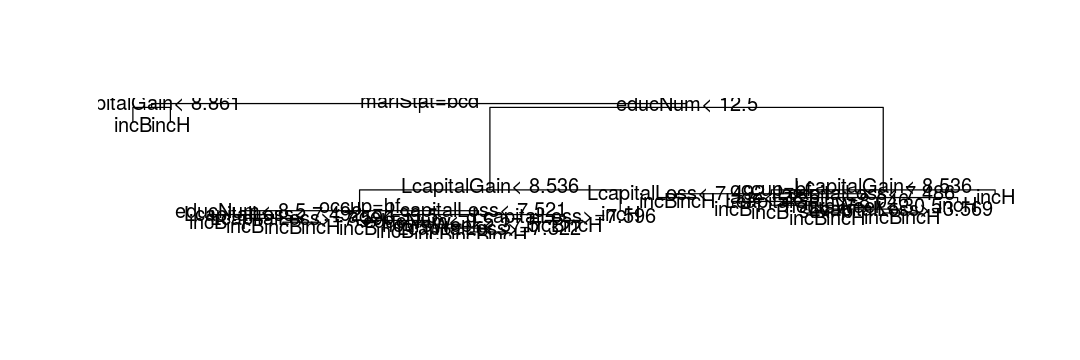

In [75]:
plot(treeInitW)
text(treeInitW)

In [76]:
# prévision des modèles
yHatTree=predict(treeInit,newdata=daTest,type="class")
yHatTreeW=predict(treeInitW,newdata=daTest,type="class")
yHatFtree=predict(tree.F,newdata=daTestF,type="class")
yHatMtree=predict(tree.M,newdata=daTestM,type="class")
# compilation des prévisions
yHatFMtree=c(yHatFtree,yHatMtree)

In [77]:
# erreurs cumulées vs. erreur initiale de rpart
table(yHatFMtree,daTestFM$income); table(yHatTree,daTest$income)

          
yHatFMtree incB incH
         1 6209  856
         2  471 1407

        
yHatTree incB incH
    incB 6340  961
    incH  340 1302

In [78]:
tauxErr(table(yHatFMtree,daTestFM$income)); tauxErr(table(yHatTree,daTest$income))

[1] 14.84

[1] 14.55

In [79]:
tauxErr(table(yHatTreeW,daTest$income))

[1] 14.69

In [80]:
# Biais cumulé vs. biais du modèle initial vs. biais de la base
round(dispImp(daTestFM[,"sex"],as.factor(yHatFMtree)),3);round(dispImp(daTest[,"sex"],as.factor(yHatTree)),3);
round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3);round(dispImp(daTest[,"sex"],as.factor(yHatTreeW)),3)

[1] 0.331 0.375 0.419

[1] 0.262 0.304 0.346

[1] 0.339 0.379 0.419

[1] 0.269 0.311 0.352

#### *Random Forest*

In [63]:
library(randomForest)
# Modèle initial
RFinit=randomForest(income~.,data=datApp)
# Modèle en changeant les poids
RFinitW=randomForest(income~.,data=datApp,weigth=w)
# estimation des deux modèles
RF.F=randomForest(income~.,data=datAppF[,-6])
RF.M=randomForest(income~.,data=datAppM[,-6])
# comparaison des paramètres

In [64]:
# prévision des modèles
yHatrf=predict(RFinit,newdata=daTest,type="response")
yHatrfW=predict(RFinitW,newdata=daTest,type="response")
yHatFrf=predict(RF.F,newdata=daTestF,type="response")
yHatMrf=predict(RF.M,newdata=daTestM,type="response")
# compilation des prévisions
yHatFMrf=c(yHatFrf,yHatMrf)

In [65]:
# erreurs cumulées vs. erreur initiale de RF
table(yHatFMrf,daTestFM$income); table(yHatrf,daTest$income)

        
yHatFMrf incB incH
       1 6282  880
       2  398 1383

      
yHatrf incB incH
  incB 6284  865
  incH  396 1398

In [66]:
tauxErr(table(yHatFMrf,daTestFM$income)); tauxErr(table(yHatrf,daTest$income))
tauxErr(table(yHatrfW,daTest$income))

[1] 14.29

[1] 14.1

[1] 14.16

In [67]:
# Biais cumulé vs. biais du modèle initial vs. biais de la base
round(dispImp(daTestFM[,"sex"],as.factor(yHatFMrf)),3);round(dispImp(daTest[,"sex"],as.factor(yHatrf)),3);
round(dispImp(daTest[,"sex"],as.factor(yHatrfW)),3);round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3)

[1] 0.349 0.396 0.443

[1] 0.332 0.378 0.423

[1] 0.328 0.373 0.418

[1] 0.339 0.379 0.419

Introduction d'une discrimination positive en réduisant le seuil de décision pour les femmes.

In [68]:
# prévision des modèles
yHatFrfDP=predict(RF.F,newdata=daTestF,type="prob")[,1]<0.7
yHatMrfDP=predict(RF.M,newdata=daTestM,type="prob")[,1]<0.5
# compilation des prévisions
yHatFMrfDP=c(yHatFrfDP,yHatMrfDP)

In [69]:
table(yHatFMrfDP,daTestFM$income)

          
yHatFMrfDP incB incH
     FALSE 6192  839
     TRUE   488 1424

In [70]:
tauxErr(table(yHatFMrfDP,daTestFM$income))

[1] 14.84

In [71]:
round(dispImp(daTestFM[,"sex"],as.factor(yHatFMrfDP)),3)

[1] 0.521 0.579 0.636

#### Synthèse graphique des résultats
Les résultats précédents: précision et intervalles de confiance ont été enregistrés dans un fichier. Il faudrait automatiser la production de ce fichier.

In [116]:
diAlgos=read.table("diVSalgos.txt",header=T)
summary(diAlgos)

            Model       Lower              DI             Upper       
 binaryTree    :1   Min.   :0.2120   Min.   :0.2480   Min.   :0.2830  
 condBinTree   :1   1st Qu.:0.2637   1st Qu.:0.3058   1st Qu.:0.3475  
 condLinLogit  :1   Median :0.2975   Median :0.3395   Median :0.3805  
 condQuadLogit :1   Mean   :0.3041   Mean   :0.3465   Mean   :0.3886  
 condRandForest:1   3rd Qu.:0.3282   3rd Qu.:0.3725   3rd Qu.:0.4165  
 condRFdiscrPos:1   Max.   :0.5060   Max.   :0.5620   Max.   :0.6190  
 (Other)       :8                                                     
    Accuracy     
 Min.   : 83.32  
 1st Qu.: 83.54  
 Median : 85.20  
 Mean   : 85.70  
 3rd Qu.: 85.67  
 Max.   :100.00  
                 

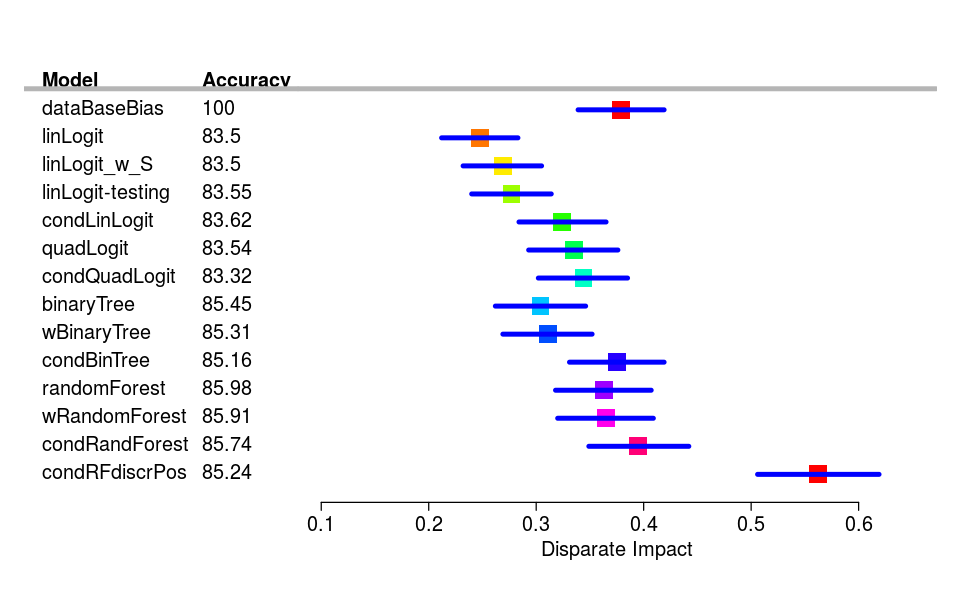

In [117]:
library(Publish)
options(repr.plot.width=8, repr.plot.height=5)
plotConfidence(x=diAlgos[,c("DI","Lower","Upper")],labels=diAlgos[,c("Model","Accuracy")],
               points.pch=15,points.cex=3,points.col=rainbow(13),
              values=FALSE,xlim=c(0.1,0.65),lwd=4,cex=1.5,
               xlab="Disparate Impact",xlab.cex=1,xratio=0.3,y.title.offset=1)

*En résumé*
- un modèle seul de régression logistique ou logistique quadratique avec le genre comme variable sensible discrimine,
- un modèle seul d'arbre binaire ou de forêt aléatoire avec le genre comme variable sensible discrimine mais pas de façon significative pour l'échantillon test considéré; c'est en revanche le cas ci-dessus en itérant par validation croisée *Monte Carlo*.
- la prise en considération de deux modèles, un par genre, conduit à un modèle qui ne discirmine plus du tout avec la régression logistique quadratique ou random forest.
- la discrimination est moindre, mais encore significativement présente, en associant deux modèles de régression logistique linéaire, en supprimant la variable sensible ou en tentant de corriger le biais par simple testing.
- la pondération pour renforcer la présence de la classe monoritaire ne suffit pas pour réduire le biais notablement.

*En conclusion*

La prise en compte simultanée des hommes et des femmes dans un mème modèle ou même algorithme renforce le biais **surtout** si le modèle est linéaire. L'association des deux modèle réduit ou annule la discrimination en séparant mieux les comportements ou modes de vie / travail selon le genre.

Une analyse des coefficients du modèle quadratique associés aux interactions montre que ce ne sont pas les mêmes interactions qui sont présentes dans le modèle sauf celle entre educNum et occupation qui est commune.

L'augmentation de biais et donc la discrimination diminuent avec la prise en compte d'interactions ou d'effets non linéaires avec un algorithme adapté (random forest). Sinon les effets linéaires triviaux se cumulent et engendrent plus d'erreurs sources de discrimination. Elle diminue d'autant plus que les modèles sont distincts pour les hommes et pour les femmes, sinon les effets appris pour les hommes majoritaires biaisent les prévisions pour les femmes. 

**Finalement, une façon simple d'éviter des décisions discriminatoires consiste à opérer des modèles ou algorihtmes différents selon les modalités de la variable sensible .... à condition que celle-ci soit observée.**

## Autresindicateurs de biais / discrimination
### Biais sur les erreurs ou précisions de prévision conditionnelles
L'effet disproportionné est une première source de biais ou de discrimination parmi bien d'autres. Une deuxième souvent évoquée concerne les erreurs de prévision ou leurs précisions; c'est  l'*overall error equality* ou de façon équivalente l'*overall accuracy equality*.

#### Régression logistique linéaire
*Overall error equality*

In [141]:
table(pred.log>0.5,daTest$income,daTest$sex)

, ,  = Female

       
        incB incH
  FALSE 2497  205
  TRUE    52  143

, ,  = Male

       
        incB incH
  FALSE 3657  745
  TRUE   474 1170


In [142]:
apply(table(pred.log>0.5,daTest$income,daTest$sex),3,tauxErr)

Female   Male 
  8.87  20.16

In [72]:
source('../Functions/overErrEqual.R')

In [73]:
overErrEqual(daTest$sex,daTest$income,as.factor(pred.log>0.5))

,inf,est_value,sup
OEE,0.3841025,0.4399963,0.4958902


In [74]:
apply(table(pred.log>0.5,daTest$income,daTest$origEthn),3,tauxErr)

CaucNo CaucYes 
  12.43   17.18

In [75]:
overErrEqual(daTest$origEthn,daTest$income,as.factor(pred.log>0.5))

,inf,est_value,sup
OEE,0.6122012,0.7236103,0.8350193


#### Deux modèles de *random forest*

un pour les hommes, un pour les femmes mais la précision pour les femmes *vs.* pour les hommes reste plus importantes pour les femmes.

In [76]:
tauxErr(table(yHatFrf,daTestF$income)); tauxErr(table(yHatMrf,daTestM$income))

[1] 7.39

[1] 17.6

Selon l'origine et surtout pour le genre, les précisions de la prévision sont très différentes mais au détriment du groupe "majoritaire", incluant sans doute plus de disparités et donc de difficultés à être prédit.

Moins de disparité pour l'association de deux forêts, une par sexe.

In [78]:
overErrEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMrf))

,inf,est_value,sup
OEE,0.3609863,0.4197511,0.4785158


In [77]:
overErrEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMrfDP))

,inf,est_value,sup
OEE,0.4500917,0.5158623,0.5816328


In [ ]:
overErrEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMrfDP))

### Asymétrie de la matrice de confusion: *equality of odds*
Une autre source de discrimination, mise en évidence par le site [Propublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) à propos du score de récidive COMPAS de la société *equivant*, concerne une inversion de l'asymétrie de la matrice de confusion selon la variable sensible. De très nombreux critères ont été proposés pour évaluer cette asymétrie et dont [Verma et Rubin (2018](http://fairware.cs.umass.edu/papers/Verma.pdf)) proposent une revue. Leurs définitions sont basées sur les différentes fréquences issues de la table de contingence et calculées par la fonction ci-dessous.

In [106]:
contRatio <- function(T){ 
    # Ratios calculés à partir de la matrice de confusion
    TP=T[2,2] # true positive
    FP=T[2,1] # false positive
    FN=T[1,2] # false negative
    TN=T[1,1]  # true negative
    PPV=TP/(TP+FP) # P(Y=1|g(x)=1) positive predictive value
    FDR=FP/(TP+FP) # P(Y=0|g(x)=1) false discovery rate 
    FOR=FN/(TN+FN) # P(Y=1|g(x)=0) false omission rate
    NPV=TN/(TN+FN) # P(Y=0|g(x)=0) negative predictive value
    TPR=TP/(TP+FN) # P(g(x)=1|Y=1) true positive rate
    FPR=FP/(FP+TN) # P(g(x)=1|Y=0) false positive rate
    FNR=FN/(TP+FN) # P(g(x)=0|Y=1) false negative rate
    TNR=TN/(FP+TN) # P(g(x)=0|Y=0) true negative rate
    return(list("PPV"=PPV,"FDR"=FDR,"FOR"=FOR,"NPV"=NPV,"TPR"=TPR,"FPR"=FPR,"FNR"=FNR,"TNR"=TNR))
}

In [107]:
contRatio(table(pred.log>0.5,daTest$income))

$PPV
[1] 0.713975

$FDR
[1] 0.286025

$FOR
[1] 0.1337275

$NPV
[1] 0.8662725

$TPR
[1] 0.5802033

$FPR
[1] 0.07874251

$FNR
[1] 0.4197967

$TNR
[1] 0.9212575

Liste de critères de loyauté pouvant être définis à partir des fréquences précédentes conditionnellement à la variable sensible. La combinatoire des possibles est importante mais peut être réduite en remarquant que *PPV*=1-*FDR*, *FOR*=1-*NPV*, *FPR*=1-*TNR*, *FNR*=1-*TPR*... Selon les auteurs, il y a loyauté de traitement si:
- *Predictive parity*: les deux groupes ont les mêmes *PPV*s et par conséquence les mêmes *FDR*s;
- *False positive error rate balance* ou *predictive equality*: mêmes *FPR*s et par conséquence les mêmes *TNR*s;
- *False negative error rate balance* ou *equal opportunity*: mêmes *FNR*s et par conséquence les mêmes *TPR*s;
- *Conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds* combine les deux ci-dessus: mêmes *TPR*s **ET** mêmes *FPR*s;
- *Overall accuracy equality*: mêmes *TPR* **ET** mêmes *TNR*;
- *Conditionnal use accuracy equality*: mêmes *PPV*s **ET** mêmes *NPV*s;
- *Teatment equality*: les rapports *FN/FP* sont les mêmes pour les deux groupes.

Bien d'autres critères ont été proposés (cf. Verma et Rubin; 2018), il ne sont pas développés ici. Les calculs des *TPR* et *TNR* conditionnels sont privilégiés ci-dessous mais ce n'est qu'un choix parmi d'autres. Friedler et al. (2019) montrent que ceux-ci sont très corrélés. il serait raisonnable de se limiter aux seules comparaisons des *TPR* et *FPR*.

#### Par genre 
##### Régression logistique linéaire
La matrice de confusion est obtenue conditionnellement aux groupes pour comparer les différents indicateurs de loyauté.

In [108]:
fairness=data.frame("Female"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$sex)[,,1])),
                    "Male"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$sex)[,,2])))
fairness

,Female,Male
PPV,0.7333333,0.7116788
FDR,0.2666667,0.2883212
FOR,0.07586973,0.1692413
NPV,0.9241303,0.8307587
TPR,0.4109195,0.6109661
FPR,0.02040016,0.1147422
FNR,0.5890805,0.3890339
TNR,0.9795998,0.8852578


Il serait fastidieux de construire toutes les comparaisons d'autant que beaucoup de ces indicateurs sont redondants (riedler et al. 2019). On s'arrête à celui: ***Equality of Odds***: La fonction  `oddsEqual`  admet 4 paramètres:
- S: variable du groupe protégé
- Y: variable cible
- P: prévision $\hat{Y}$
- alpha=0.05, valeur par défaut.

Elle fournit l'estimation par intervalle de confiance des rapports des *FPR* et *TPR* conditionnels et permet donc de tester l'égalité ou non des cotes selon la variable sensible.

In [163]:
source('../Functions/oddsEqual.R')

In [167]:
round(oddsEqual(daTest$sex,daTest$income,as.factor(pred.log>0.5)),2)

,inf,est_value,sup
FPR,0.13,0.18,0.23
TPR,0.58,0.67,0.76


##### *Random forest* avec deux modèles

In [109]:
fairnessRF=data.frame("Female"=as.matrix(contRatio(table(yHatFrf,daTestF$income))),
                    "Male"=as.matrix(contRatio(table(yHatMrf,daTestM$income))))
fairnessRF

,Female,Male
PPV,0.738676,0.7831565
FDR,0.261324,0.2168435
FOR,0.05210728,0.1617453
NPV,0.9478927,0.8382547
TPR,0.6091954,0.6167102
FPR,0.0294233,0.07915759
FNR,0.3908046,0.3832898
TNR,0.9705767,0.9208424


Il n'est pas simple de comparer toutes ces quantités. Il apparaît néanmoins, en réumé, que
- pour la **régression logistique** la plus élémentaire (linéaire) qui provoque le plus de discrimination,
    - les taux de faux positifs (*FPR*) sont nettement en faveur des hommes contrairement aux taux de faux négatifs; 
    - il y a certes plus d'erreurs de prévision à leur encontre mais, c'est finalement à leur avantage avec proportionnellement plus de faux positifs. 
- pour le modèle associant deux **forêts aléatoires**, une par sexe, *FPR* et *TPR* prennent, conditionnellement au genre, des valeurs plus proches. Les *TPR* sont identiques et les *FPR* plus proches avec un rapport de 0.38 au lieu de 0.18.

*Conclusion provisoire*: 
- Il est facile dans la commande ci-dessus de modifier le seuil de décision (0.35 au lieu de 0.5) pour les femmes. Cela a pour effet dans la section précédente de réduire significativement l'effet disproportionné mais l'effet sur la comparaison des taux de faux positifs est mineur.
- En revanche l'association de deux modèles de RF qui élimine la discrimination mesurée par le *DI* mais conserve des taux d'erreur très différents, conduit à des FPR identiques selon le genre. A l'exception des taux d'erreur, les sources de discrimination de la décision algorithmique sont réduits voire éliminées mais sans pour autant corriger les biais de société.

#### Par origine

In [116]:
fairness2=data.frame("CaucNo"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$origEthn)[,,1])),
                    "CaucYes"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$origEthn)[,,2])))
fairness2

,CaucNo,CaucYes
PPV,0.7006803,0.71513
FDR,0.2993197,0.28487
FOR,0.1014235,0.1397993
NPV,0.8985765,0.8602007
TPR,0.4746544,0.5913978
FPR,0.04174573,0.08567366
FNR,0.5253456,0.4086022
TNR,0.9582543,0.9143263


In [166]:
round(oddsEqual(daTest$origEthn,daTest$income,as.factor(pred.log>0.5)),2)

,inf,est_value,sup
FPR,0.34,0.49,0.63
TPR,0.69,0.80,0.92


Même remarque mais à un degré moindre.

## *Testing* et détection de discrimination individuelle
###  Introduction
La section précédente est focalisée sur une détection de la *discrimination de groupe*. Celle-ci n'est pas pratiquée en France ni même en Europe alors que plusieurs rapports dont celui de la commission Villani y font référence. Ce dernier demande la création d'un *discrimination impact assessment* pour aborder cette question mais sans apporter de précision ni faire référence à la pourtant abondante littérature du sujet.

En revanche, la détection d'une *discrimination individuelle* est pratiquée de longue date (1939 pour les boîtes de nuit) en faisant appel à des expérimentations spécifiques dites de *testing*; consulter un [Historique](https://fr.wikipedia.org/wiki/Test_de_discrimination) à ce sujet. 

Les cours de justice acceptent le *testing* comme élément de preuve d'une discrimination à l'embauche depuis un [arrêté](https://www.juritravail.com/discrimination-physique/embauche/ph-alternative-A-1.html) de 2016 de la cours de cassation même si ce procédé peut être considéré comme déloyal.

Le test de discrimination ou *testing* automatique est pratiqué en France de façon systématique pour des études sociologiques par l'[Observatoire des discriminations](http://www.observatoiredesdiscriminations.fr/testing), le laboratoire TEPP: [L'Horty et al. (2017)](http://www.tepp.eu/doc/users/268/bib/banque-et-assurance_9025.pdf), ou pilotée par la [DARES](http://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/etudes-et-syntheses/dares-analyses-dares-indicateurs-dares-resultats/testing) du Ministère du Travail en lien avec l'association [ISM Corum](http://www.ismcorum.org/). Certains entreprises demandent d'ailleurs à ISM Corum de [tester leur mode de recrutement](http://www.ismcorum.org/le-testing-d-entreprise-%E2%80%93-temoignages-d-adecco-casino-lvmh-michael-page-M22-R22-A443.html).  L'observatoire des discriminations propose un [audit qualité](http://www.observatoiredesdiscriminations.fr/diagnostics-qualite) des procédures de recrutement et [Novethic](https://www.novethic.fr/lexique/detail/testing.html), filliale de la caisse des dépôts et consignation, donne des formations pour des entreprises "éthiques".

L'objectif de cette section est d'expérimenté le *testing* sur la robustesse du modèle de prévision précédent. 

*Existe-t-il des personnes pour lesquelles le seul changement de genre ou d'origine a pour effet de changer la prévision du seuil de revenu `income` en leur défaveur?*

Personnes qui seraient en droit d'entreprendre une action en justice dans le cas d'une décision impactante, crédit, emploi.... Elles apporteraient ainsi la preuve de leur discrimination.

Le processus est simple, il suffit de modifier l'échantillon test en *échangeant les deux modalités de la variables sensible*. La variable cible (seuil de revenu) est ensuite reprédite en utilisant le même modèle initial. 

Evidemment, comme pour l'estimation du *disparate impact*, il est nécessaire de disposer de la variable sensible (genre ou origine) pour pouvoir opérer du *testing* automatique.


### Personnes discriminées selon leur genre

In [47]:
daTest2=daTest
# Changement de genre
daTest2$sex=as.factor(ifelse(daTest$sex=="Male","Female","Male"))
# Prévision du "nouvel" échantillon test
pred2.log=predict(log.lm,daTest2,type="response")

In [50]:
table(pred.log<0.5,pred2.log<0.5)

       
        FALSE TRUE
  FALSE  1684  155
  TRUE     23 7081

Même chose mais répartition par genre.

In [51]:
table(pred.log<0.5,pred2.log<0.5,daTest$sex)

, ,  = Female

       
        FALSE TRUE
  FALSE   195    0
  TRUE     23 2679

, ,  = Male

       
        FALSE TRUE
  FALSE  1489  155
  TRUE      0 4402


**N.B.** Il y a 178 personnes dont la prévision de revenu change lorsqu'elles changent de genre. Et le changement est dans le sens attendu.
- 23 femmes passent d'une prévision de revenu faible à une prévision de revenu élevé
- 155 hommes prennnent le chemin inverse  lorsqu'ils deviennent des femmes; ces hommes bénificient donc d'une discrimination positive.

### Personnes discriminées selon leur origine
Mêmes calculs vis-à-vis de la variable sensible origine.

In [91]:
daTest3=daTest
daTest3$origEthn=as.factor(ifelse(daTest$origEthn=="CaucYes","CaucNo","CaucYes"))
# Prévision du "nouvel" échantillon test
pred3.log=predict(log.lm,newdata=daTest3,type="response")

Comme pour la discrimination selon le genre, la détection de personnes discriminées selon leur origine est nette. Les prévisions de seuil de revenu de 160 personnes sont affectées par le changement d'origine.
- 15 sont discriminées par leur origine
- 177 bénéficient d'une discrimination positive

In [92]:
table(pred.log<0.5,pred3.log<0.5)

       
        FALSE TRUE
  FALSE  1662  177
  TRUE     15 7089

In [93]:
table(pred.log<0.5,pred3.log<0.5,daTest$origEthn)

, ,  = CaucNo

       
        FALSE TRUE
  FALSE   147    0
  TRUE     15 1109

, ,  = CaucYes

       
        FALSE TRUE
  FALSE  1515  177
  TRUE      0 5980


### *Testing* et prévision "déloyale" 
Une façon simple pour une entreprise de se prémunir contre une opération de *testing* consiste à fixer comme probablité prédite le maximum des deux probablités obtenues en échangeant les modalités de la variable sensible. De façon générale, choisir la situation la plus favorable pour la personne quelque soit le genre (resp. l'origine) observé. La discrimination individuelle repérable par *testing* est neutralisée et l'influence sur le taux d'erreur quasi négligeable. 

#### Genre

In [94]:
fairPredictGenre=ifelse(pred.log<pred2.log,pred2.log,pred.log)
confMat=table(fairPredictGenre>0.5,daTest$income)
confMat;tauxErr(confMat)

       
        incB incH
  FALSE 6145  936
  TRUE   535 1327

[1] 16.45

In [95]:
round(dispImp(daTest$sex,as.factor(pred.log>0.5)),3)
round(dispImp(daTest$sex,as.factor(fairPredictGenre>0.5)),3)

[1] 0.212 0.248 0.283

[1] 0.240 0.277 0.314

La correction par *testing* réduit un peu le biais mais de façon insuffisante pour réduire significativement la discrimination.

#### Origine

Des résulats simiulaires sont obtenus.

In [96]:
fairPredictOrig=ifelse(pred.log<pred3.log,pred3.log,pred.log)
confMat=table(fairPredictOrig>0.5,daTest$income)
confMat;tauxErr(confMat)

       
        incB incH
  FALSE 6144  945
  TRUE   536 1318

[1] 16.56

In [62]:
round(dispImp(daTest$origEthn,as.factor(pred.log>0.5)),3)
round(dispImp(daTest$origEthn,as.factor(fairPredictGenre>0.5)),3)

[1] 0.367 0.444 0.520

[1] 0.378 0.454 0.531

La correction qui rend la décision localement loyale c'est-à-dire en supprimant toute discrimination individuelle n'a qu'un impact très marginal sur l'erreur de prévision. De plus, cette "correction" du biais permet d'échapper à une poursuite juridique individuelle mais ne corrige globalement pas l'effet disproportioné et donc le biais de groupe. Cette correction est *factice* et pour le moins *déloyale*. 

## Conclusions
1. Ces données de sondage présentent des biais sociologiques attenuds vis-à-vis des groupes de genre et d'origine ethnique. Le biais, mesuré par l'effet disproportionné (*Disparate impact* ou *DI*), est nettement plus marqué conditionnellement au genre.
2. Une prévision du seuil avec un algorithme d'apprentissage reproduit voire amplifie ce biais: le *DI* décroît. C'est même statistiquement significatif pour pour le genre avec la régression logistique linéaire (sans interaction): intervalles de confiance du *DI* disjoints; c'est plus modéré pour l'origine. *Un modèle linéaire opère une discrimination conditionnellement au genre*. 
3. *Comme la précision, l'augmentation du biais dépend de l'algorithme opéré*. Sur ces points, les forêts aléatoires sont plus performantes que la régression logistique, sur-biaisent moins mais sont opaques à une interprétation. 
4. L'itération de la séparation aléatoire des échantillons apprentissage / test par validation croisée *Monte Carlo* révèle une instabilité importante de l'estimation du *DI*, même sur une relativement grosse base de données, mais confirme l'effet discriminatoire des algorithmes.
5. La détection d'une discrimination individuelle par *testing* montre que peu de femmes ou de non-caucasiens pourraient se déclarer discriminés par la prévision et être donc en mesure, individuellement, de porter plainte. Cette mesure individuelle de la discrimination, est finalement assez annecdotique au regard de la mesure de discrimination de groupe; autrement dit, sur cet exemple, *une mesure individuelle de la discrimination par testing minimise son importance*. 
6. Corriger la prévision pour attribuer la prévision la plus favorable quel que soit la modalité sensible, permet à une entreprise ou administration d'échapper à une investigation par *testing* mais ne fait en rien décroîte le biais (accroître le *DI*) donc la discrimination de groupe. Ce serait une *pratique tout à fait déloyale, voire condamnable*.
7. La suppression des variables sensibles de la prévision ne change rien aux points 2 et 3 précédents. C'est une *procédure naïve et inefficace pour corriger le *DI* donc un biais de groupe*.
8. **Résultat important** à évaluer sur d'autres sources de données: une façon simple d'éviter des décisions discriminatoires, mais sans toucher au biais de société, consiste à opérer des algorithmes  *non linéaires* (arbre, forêt), *un pour chaque modalité* de la variable sensible.
9. Les taux d'erreurs conditionnels aux variables sensibles sont assez différents; une estimation par intervalle de confiance serait bienvenue. *L'accroissement de l'erreur est dans ce cas au détriment de la classe majoritaire* et se retrouve pour tous les algorithmes linéaires ou non.
10. Après l'effet disproportionné (*DI*) et les taux d'erreur conditionnels, il est important de considérer les éventuelles *asymétries des matrices de confusion conditionnelles* (*equality of odds*) aux variables sensibles. Le rapport des taux de faux positifs conditionnels ainsi que celui des taux de faux négatifs conditionnels témoignent de différences de traitement marqués relativement aux groupes. Pour la régression logistique, Les taux d'erreurs sont effectivement importants pour les hommes mais c'est finalement à leur avantage car le *taux de faux positifs est significativement plus important les concernant au contraire des taux de faux négatifs plus importants pour les femmes*. En cas d'erreur celle-ci est donc en moyenne au profit des hommes; ce phénomène est moins marqué conditionnellement à l'origine ethnique. 
11. **Suite**: Comme pour le *DI*, l'*association de deux algorihtmes non linéaires* (arbre ou forêt) ne corrige pas le biais sur les taux d'erreur mais semble le réduire sur les taux de faux positifs et faux négatifs conditionnels. 
12. En France, comme en Europe, il y a une part d'hypocrisie à interdire l'enregistrement d'une variable sensible. Certes, cela protège la confidentialité des personnes mais empêche aussi de mettre simplement en évidence biais et discriminations des traitements vis-à-vis d'un groupe ou des individus. 
13. Une pratique parfois jugée déloyale et qui consiste à adapter le seuil de décision de la prévision, le baisser pour le groupe à protéger, réduit significativement le biais pour le *rendre similaire à celui de la base d'entraînement*; il n'y a plus discrimination de groupe. La procédure qui consisterait à réduire plus le seuil pour corriger le biais de société revient à introduire une discrimination positive. Il s'agit d'un choix politique et non plus statistique. Dans ce cas, l'erreur de prévision se dégrade. D'autres corrections de biais en contrôlant l'erreur de prévision sont à considérer pour conduire à de l'*apprentissage loyal* et donc à une *IA éthique*. C'est l'objet d'un autre tutoriel en python.

## Références
Barocas S., Selbst A. (2016). Big Data's Disparate Impact, *California Law Review*, 671.

Besse P. ,del Barrio E., Gordaliza P., Loubes J.-M. (2018). Confidence Intervals for testing Disparate Impact in Fair Learning, [arXiv](https://arxiv.org/abs/1807.06362).

Calders T., Verwer S. (2010). Three naive Bayes approaches for discrimination-free classification, Data Mining and Knowledge Discovery, 21 (2), pp 277–292.

Friedler S., Scheidegger C., Venkatasubramanian S., Choudhary S., Hamilton E., Roth D. (2019). A comparative study of fairness-enhancing interventions in machine learning, Proceedings of the Conference on Fairness, Accountability, and Transparency.

Verma S., Rubin J. (2018). [Fairness Definitions Explained](http://fairware.cs.umass.edu/papers/Verma.pdf),  ACM/IEEE International Workshop on Software Fairness.